# Attention readout and visualisation

In [1]:
# this file uses the environment called attentionviz2

/home/ifender/miniconda3/envs/attentionviz2/bin/python


In [11]:

from rdkit import Chem
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from rdkit.Chem import rdmolops
from rdkit import RDConfig
import os
import sys
#plotting
from IPython.display import SVG
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from collections import namedtuple
import torch
from IPython.display import SVG
from IPython.display import Image, display
import io
import numpy as np
import re

In [1]:
#to import to get attention from model
from attention_readout import gather_attention
from constants import PREDICTION_MODEL_PATH, PARSING_REGEX

2024-06-12 18:14:21 | INFO | fairseq.tasks.text_to_speech | Please install tensorboardX: pip install tensorboardX


## Functions

In [5]:
def clean_SMILES(SMILES_tok):
    """Removing structural tokens, hydrogens, and numbers from SMILES token input

    Args:
        SMILES_tok (_list_): List of SMILES_tokens for a given SMILES

    Returns:
        _list,list_: Processed SMILES_token list and list of positions in input tokens list that were kept
        (needed to distinguish which embeddings are relevant)
    """
    SMILES_tok_prep = list()
    struc_toks = r"()=:~1234567890#"
    posToKeep = list()
    pos = 0
    for i in range(len(SMILES_tok)):
        # when it's an H in the SMILES, ignore, cannot deal
        if SMILES_tok[i] != "H" and SMILES_tok[i] != "h" and not SMILES_tok[i].isdigit() and not SMILES_tok[i].isspace():
            if any(elem in struc_toks for elem in SMILES_tok[i]) == False:
                if SMILES_tok[i] != "-":
                    SMILES_tok_prep.append(SMILES_tok[i])
                    # keep pos where you keep SMILES token
                    posToKeep.append(pos)
        pos += 1
    assert(len(posToKeep) == (len(SMILES_tok_prep))
           ), f"Length of positions-to-keep-array ({len(posToKeep)}) and length of SMILES_tok_prep ({len(SMILES_tok_prep)}) are not the same"
    print("SMILES_tok: ", SMILES_tok)
    print("posToKeep: ", posToKeep)
    print("SMILES_tok_prep: ", SMILES_tok_prep)

    return SMILES_tok_prep, posToKeep


In [4]:

def cleanAndNormalizeAttention(attention_array,posToKeep,clean_smiles):
    # filter attention tensor according to posToKeep to only keep attention for non-hydrogen atoms
    filtered_attentions = attention_array[posToKeep]
    print(len(filtered_attentions))
    assert len(clean_smiles)==len(filtered_attentions), "Assert failed"
    # condense attention depending on method chosen
    mean_values = np.mean(filtered_attentions)
    min_val = np.min(filtered_attentions)
    max_val = np.max(filtered_attentions)
    normalized_means = (filtered_attentions - min_val) / (max_val - min_val)
    print("before normalisation: ",filtered_attentions)
    print("normalized means where all values fall between 0 and 1: ",normalized_means)
    return normalized_means



In [3]:
def drawMoleculeWithAttention(orig_smiles,clean_smiles,norm_attentions):

    # Generate a color map from 0-1 scaled to attentions
    min_val = norm_attentions.min()
    max_val = norm_attentions.max()
    print(f"Minimum and maximum attention values: {min_val}, {max_val}")
    norm = mcolors.Normalize(vmin=min_val, vmax=max_val)
    scalar_map = plt.cm.ScalarMappable(norm=norm, cmap='viridis')

    mol = Chem.MolFromSmiles(orig_smiles)
    drawer = rdMolDraw2D.MolDraw2DCairo(300, 300)
    mol_with_style = rdMolDraw2D.PrepareMolForDrawing(mol, kekulize=False)

    # Set the drawing options
    opts = drawer.drawOptions()

    # Create a color map for the atoms
    atom_colors = {i: scalar_map.to_rgba(norm_attentions[i])[:-1] for i in range(mol.GetNumAtoms())}  # Remove alpha channel

    # Draw the molecule with colored atoms according to attention scores
    AllChem.Compute2DCoords(mol)
    d = rdMolDraw2D.MolDraw2DSVG(400, 400)
    rdMolDraw2D.PrepareAndDrawMolecule(d, mol, highlightAtoms=range(mol.GetNumAtoms()),
                                      highlightAtomColors=atom_colors)

    d.FinishDrawing()
    # get the SVG string
    svg = d.GetDrawingText()
    # fix the svg string and display it
    display(SVG(svg.replace('svg:','')))

    # Colorbar
    plt.figure(figsize=(4.5, 0.5))
    img = np.array([[min_val, max_val]])
    plt.imshow(img, cmap='viridis')
    plt.gca().set_visible(False)
    cax = plt.axes([0.1, 0.2, 0.8, 0.6])
    colba = plt.colorbar(cax=cax, orientation="horizontal")
    colba.set_label('Attention Score')
    plt.savefig("test.png")
    plt.show()

In [2]:
def colorAtomsByAttention(smiles):
    #tokenize, only atomwise supported
    #smiles_tok = re.findall(r'Cl|.', smiles)
    smiles_tok = [elem for elem in re.split(PARSING_REGEX,smiles) if elem]
    clean_smiles,posToKeep = clean_SMILES(smiles_tok)
    # get attention from model, only BART for now
    attention = gather_attention(smiles,
                 smiles_atom_path=PREDICTION_MODEL_PATH/"smiles_atom_isomers_bart"/"checkpoint_last.pt",
                 smiles_sentencepiece_path=PREDICTION_MODEL_PATH/"smiles_trained_isomers_bart"/"checkpoint_last.pt",
                 selfies_atom_path=PREDICTION_MODEL_PATH/"selfies_atom_isomers_bart"/"checkpoint_last.pt",
                 selfies_sentencepiece_path=PREDICTION_MODEL_PATH/"selfies_trained_isomers_bart"/"checkpoint_last.pt")
    # remove attention on hydrogens, numbers, structural tokens and minmax normalize attention to values between 0 and 1
    norm_attention = cleanAndNormalizeAttention(attention,posToKeep,clean_smiles)
    # draw molecule with colored atoms according to attention scores
    drawMoleculeWithAttention(smiles,clean_smiles,norm_attention)

## Main

### Choose SMILES and get only the atoms from it

In [12]:
# get rid of structural topkens and hydrogens in SMILES
smiles="CC=CCOCC"
#only care about atomwise tokenisation
smiles_tok = [elem for elem in re.split(PARSING_REGEX,smiles) if elem]
clean_smiles,posToKeep = clean_SMILES(smiles_tok)

SMILES_tok:  ['C', 'C', '=', 'C', 'C', 'O', 'C', 'C']
posToKeep:  [0, 1, 3, 4, 5, 6, 7]
SMILES_tok_prep:  ['C', 'C', 'C', 'C', 'O', 'C', 'C']


### Decide on the model to analyze and gather the attention for the previously chosen SMILES

In [8]:
attention = gather_attention(smiles,
                 smiles_atom_path=PREDICTION_MODEL_PATH/"smiles_atom_isomers_bart"/"checkpoint_last.pt",
                 smiles_sentencepiece_path=PREDICTION_MODEL_PATH/"smiles_trained_isomers_bart"/"checkpoint_last.pt",
                 selfies_atom_path=PREDICTION_MODEL_PATH/"selfies_atom_isomers_bart"/"checkpoint_last.pt",
                 selfies_sentencepiece_path=PREDICTION_MODEL_PATH/"selfies_trained_isomers_bart"/"checkpoint_last.pt")


2024-06-12 15:22:36 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/smiles_atom_isomers_bart
2024-06-12 15:22:36 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/bbbp/smiles_atom_isomers
2024-06-12 15:22:36 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
/home/ifender/miniconda3/envs/attentionviz2/lib/python3.10/site-packages/torch/cuda/__init__.py:118: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11080). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0
2024-06-12 15:22:38 | INFO | fairseq.models.bart.model | Regis

### Remove attention on structural tokens and hydrogens

In [12]:
norm_attention = cleanAndNormalizeAttention(attention,posToKeep,clean_smiles)

7
before normalisation:  [0.06893153 0.15361978 0.1629039  0.13042225 0.11900432 0.15390348
 0.10909128]
normalized means where all values fall between 0 and 1:  [0.         0.90120369 1.         0.6543489  0.53284583 0.9042227
 0.42735701]


### Draw Molecule

Minimum and maximum attention values: 0.0, 1.0


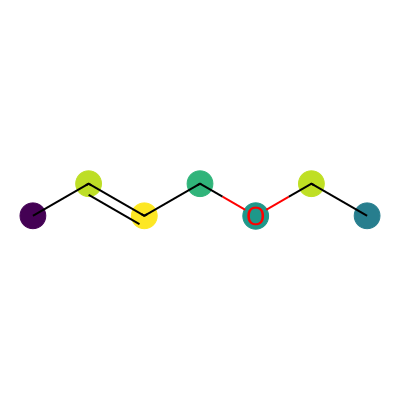

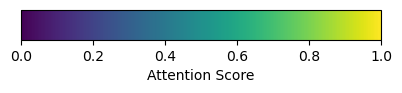

In [13]:
drawMoleculeWithAttention(smiles,clean_smiles,norm_attention)

## SMILES to look into:
### Looking into attention differences in symmetrical molecules:

1) c1cc2ccc3cccc4ccc(c1)c2c34 (Highly symmetrical (4 benzol rings))

2) O=CNC(N1C=CN(C(NC=O)C(Cl)(Cl)Cl)C=C1)C(Cl)(Cl)Cl (Also very symmetrical, espc. Ns, Cls and Os in similar positions interesting to compare attention)

3) c1ccc(-c2ccc(-c3ccccc3)cc2)cc1 (three benzol rings in a chain)

4) c1ccc2c(c1)sc1ccccc12 (2 benzol rings, one five-ring )

### Looking into differences in hydrophobicity:

5) C1=CC=CC=C1 (Benzol, Solubility in water: 1.84 g/L (30 °C) (see: https://en.wikipedia.org/wiki/Benzene))

6) CC(OC1=C(C(=O)O)C=CC=C1)=O CC(=O)OC1C=CC=CC=1C(O)=O (Aspirin, Solubility in water 3g/L (see: https://en.wikipedia.org/wiki/Aspirin))

7) C1=CC(=CC=C1C(=O)O)O (PHBA (found in: https://www.sciencedirect.com/science/article/pii/S095965262030247X#fig1), Solubility in Water 5g/L at 25 °C (https://pubchem.ncbi.nlm.nih.gov/compound/135#section=Melting-Point))

8) CCCCOC(=O)C1=CC=C(C=C1)N (Butyl 4-aminobenzoate (see: https://pubchem.ncbi.nlm.nih.gov/compound/2482#section=Melting-Point), Solubility in Water: 0.14g/L (no temperature stated))

## Symmetry within molecules

2024-06-12 18:15:56 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/smiles_atom_isomers_bart
2024-06-12 18:15:56 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/bbbp/smiles_atom_isomers


SMILES_tok:  ['c', '1', 'c', 'c', '2', 'c', 'c', 'c', '3', 'c', 'c', 'c', 'c', '4', 'c', 'c', 'c', '(', 'c', '1', ')', 'c', '2', 'c', '3', '4']
posToKeep:  [0, 2, 3, 5, 6, 7, 9, 10, 11, 12, 14, 15, 16, 18, 21, 23]
SMILES_tok_prep:  ['c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c']


2024-06-12 18:15:57 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
/home/ifender/miniconda3/envs/attentionviz2/lib/python3.10/site-packages/torch/cuda/__init__.py:118: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11080). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0
2024-06-12 18:15:58 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head


16
before normalisation:  [0.01732512 0.0463205  0.07805961 0.05226177 0.04052735 0.04309419
 0.02633271 0.02514527 0.02384851 0.02334529 0.02311009 0.06307255
 0.03149052 0.0223051  0.02169168 0.0207397 ]
normalized means where all values fall between 0 and 1:  [0.         0.47741206 1.         0.57523576 0.38202719 0.42429057
 0.14831088 0.12875958 0.10740833 0.09912276 0.09525017 0.75323653
 0.23323482 0.08199591 0.07189586 0.0562213 ]
Minimum and maximum attention values: 0.0, 1.0


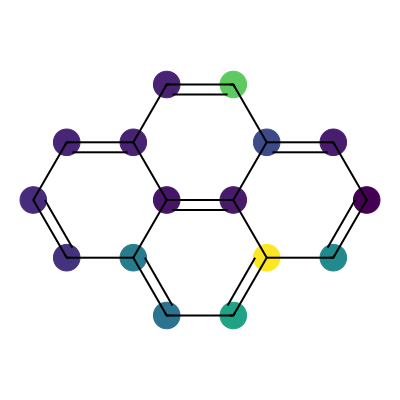

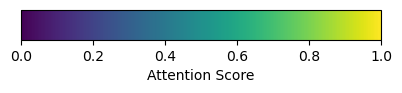

In [13]:
#1. c1cc2ccc3cccc4ccc(c1)c2c34
smiles="c1cc2ccc3cccc4ccc(c1)c2c34"
colorAtomsByAttention(smiles)

2024-06-12 18:16:03 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/smiles_atom_isomers_bart
2024-06-12 18:16:03 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/bbbp/smiles_atom_isomers


SMILES_tok:  ['O', '=', 'C', 'N', 'C', '(', 'N', '1', 'C', '=', 'C', 'N', '(', 'C', '(', 'N', 'C', '=', 'O', ')', 'C', '(', 'Cl', ')', '(', 'Cl', ')', 'Cl', ')', 'C', '=', 'C', '1', ')', 'C', '(', 'Cl', ')', '(', 'Cl', ')', 'Cl']
posToKeep:  [0, 2, 3, 4, 6, 8, 10, 11, 13, 15, 16, 18, 20, 22, 25, 27, 29, 31, 34, 36, 39, 41]
SMILES_tok_prep:  ['O', 'C', 'N', 'C', 'N', 'C', 'C', 'N', 'C', 'N', 'C', 'O', 'C', 'Cl', 'Cl', 'Cl', 'C', 'C', 'C', 'Cl', 'Cl', 'Cl']


2024-06-12 18:16:03 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2024-06-12 18:16:04 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head


22
before normalisation:  [0.01173684 0.02129836 0.01428813 0.02295421 0.01746172 0.05337209
 0.02118052 0.01629077 0.0405372  0.01986378 0.16847746 0.02538118
 0.02308554 0.01964906 0.02146365 0.02257605 0.02203605 0.02063477
 0.01993121 0.02378906 0.02182006 0.02197297]
normalized means where all values fall between 0 and 1:  [0.         0.06100218 0.01627717 0.07156649 0.03652454 0.26563153
 0.06025039 0.02905398 0.1837454  0.05184965 1.         0.08705045
 0.07240438 0.05047974 0.06205677 0.06915385 0.06570865 0.05676854
 0.05227986 0.07689282 0.06433064 0.0653062 ]
Minimum and maximum attention values: 0.0, 1.0


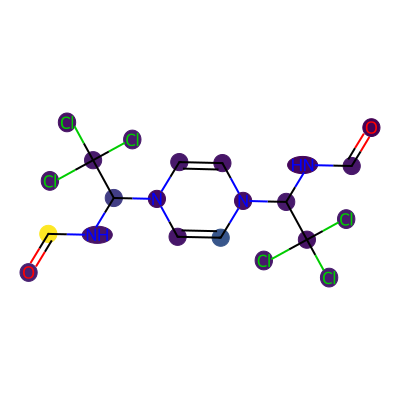

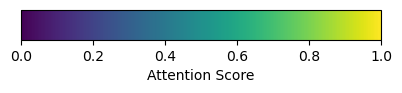

In [14]:
#2. O=CNC(N1C=CN(C(NC=O)C(Cl)(Cl)Cl)C=C1)C(Cl)(Cl)Cl
smiles="O=CNC(N1C=CN(C(NC=O)C(Cl)(Cl)Cl)C=C1)C(Cl)(Cl)Cl"
colorAtomsByAttention(smiles)

2024-06-12 18:16:10 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/smiles_atom_isomers_bart
2024-06-12 18:16:10 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/bbbp/smiles_atom_isomers


SMILES_tok:  ['c', '1', 'c', 'c', 'c', '(', '-', 'c', '2', 'c', 'c', 'c', '(', '-', 'c', '3', 'c', 'c', 'c', 'c', 'c', '3', ')', 'c', 'c', '2', ')', 'c', 'c', '1']
posToKeep:  [0, 2, 3, 4, 7, 9, 10, 11, 14, 16, 17, 18, 19, 20, 23, 24, 27, 28]
SMILES_tok_prep:  ['c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c']


2024-06-12 18:16:10 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2024-06-12 18:16:12 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head


18
before normalisation:  [0.01297912 0.04334458 0.06802297 0.11349978 0.06073381 0.03111555
 0.02986206 0.02397736 0.01561408 0.02546553 0.021467   0.01703729
 0.01650503 0.01588189 0.01616044 0.01646642 0.0142598  0.01443379]
normalized means where all values fall between 0 and 1:  [0.         0.30208176 0.54758747 1.         0.47507335 0.18042489
 0.16795491 0.10941276 0.02621317 0.12421734 0.08443919 0.04037153
 0.03507653 0.02887741 0.03164843 0.03469243 0.01274054 0.01447139]
Minimum and maximum attention values: 0.0, 1.0


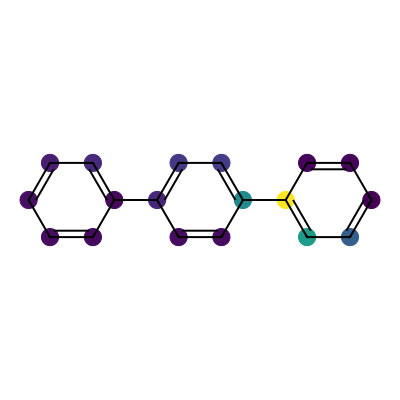

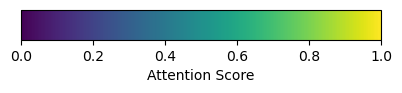

In [15]:
#3. c1ccc(-c2ccc(-c3ccccc3)cc2)cc1
smiles="c1ccc(-c2ccc(-c3ccccc3)cc2)cc1"
colorAtomsByAttention(smiles)

2024-06-12 18:16:14 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/smiles_atom_isomers_bart
2024-06-12 18:16:14 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/bbbp/smiles_atom_isomers


SMILES_tok:  ['c', '1', 'c', 'c', 'c', '2', 'c', '(', 'c', '1', ')', 's', 'c', '1', 'c', 'c', 'c', 'c', 'c', '1', '2']
posToKeep:  [0, 2, 3, 4, 6, 8, 11, 12, 14, 15, 16, 17, 18]
SMILES_tok_prep:  ['c', 'c', 'c', 'c', 'c', 'c', 's', 'c', 'c', 'c', 'c', 'c', 'c']


2024-06-12 18:16:14 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2024-06-12 18:16:16 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head


13
before normalisation:  [0.01846222 0.03847004 0.03993772 0.03986602 0.04589249 0.03350832
 0.04742512 0.03087555 0.02533346 0.05050772 0.0346674  0.02755889
 0.02632621]
normalized means where all values fall between 0 and 1:  [0.         0.62435672 0.67015643 0.66791897 0.85597869 0.46952288
 0.90380545 0.38736593 0.21442138 1.         0.50569279 0.28386745
 0.24540073]
Minimum and maximum attention values: 0.0, 1.0


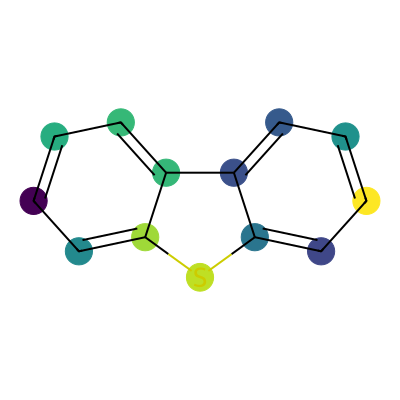

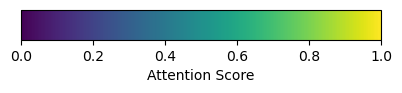

In [16]:
#4. c1ccc2c(c1)sc1ccccc12
smiles="c1ccc2c(c1)sc1ccccc12"
colorAtomsByAttention(smiles)

## Looking into different attention in hydrophobicity

2024-06-12 18:16:19 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/smiles_atom_isomers_bart
2024-06-12 18:16:19 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/bbbp/smiles_atom_isomers


SMILES_tok:  ['C', '1', '=', 'C', 'C', '=', 'C', 'C', '=', 'C', '1']
posToKeep:  [0, 3, 4, 6, 7, 9]
SMILES_tok_prep:  ['C', 'C', 'C', 'C', 'C', 'C']


2024-06-12 18:16:19 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2024-06-12 18:16:20 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head


6
before normalisation:  [0.04784407 0.10753348 0.10106575 0.19432621 0.12248549 0.06644734]
normalized means where all values fall between 0 and 1:  [0.         0.40748591 0.36333225 1.         0.50955987 0.12700026]
Minimum and maximum attention values: 0.0, 1.0


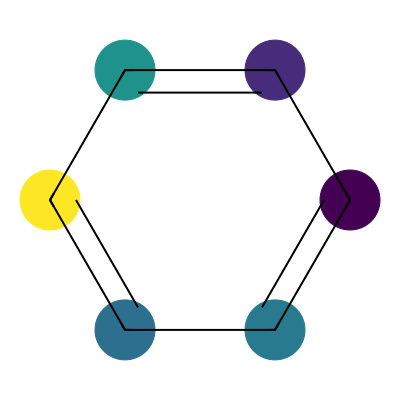

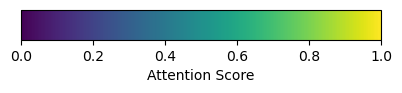

In [17]:
#5. C1=CC=CC=C1
smiles="C1=CC=CC=C1"
colorAtomsByAttention(smiles)

2024-06-12 18:16:23 | ERROR | root | failed to parse input
	SMILES: CC(OC1=C(C(=O)O)C=CC=C1)=O CC(=O)OC1C=CC=CC=1C(O)=O
2024-06-12 18:16:23 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/smiles_atom_isomers_bart
2024-06-12 18:16:23 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/bbbp/smiles_atom_isomers


SMILES_tok:  ['C', 'C', '(', 'O', 'C', '1', '=', 'C', '(', 'C', '(', '=', 'O', ')', 'O', ')', 'C', '=', 'C', 'C', '=', 'C', '1', ')', '=', 'O', ' ', 'C', 'C', '(', '=', 'O', ')', 'O', 'C', '1', 'C', '=', 'C', 'C', '=', 'C', 'C', '=', '1', 'C', '(', 'O', ')', '=', 'O']
posToKeep:  [0, 1, 3, 4, 7, 9, 12, 14, 16, 18, 19, 21, 25, 27, 28, 31, 33, 34, 36, 38, 39, 41, 42, 45, 47, 50]
SMILES_tok_prep:  ['C', 'C', 'O', 'C', 'C', 'C', 'O', 'O', 'C', 'C', 'C', 'C', 'O', 'C', 'C', 'O', 'O', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'O', 'O']


2024-06-12 18:16:23 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2024-06-12 18:16:25 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head


26
before normalisation:  [0.01028921 0.01944921 0.01433563 0.01545835 0.00943689 0.01189919
 0.02670688 0.02783264 0.02156472 0.01743331 0.01227448 0.04016934
 0.04941792 0.03227781 0.03348265 0.01824608 0.01571381 0.01874536
 0.01562136 0.01472175 0.01496103 0.01355485 0.01391437 0.01423884
 0.01952189 0.0145347 ]
normalized means where all values fall between 0 and 1:  [0.02131819 0.25042671 0.12252646 0.15060779 0.         0.06158678
 0.43195454 0.46011199 0.30333965 0.20000539 0.07097331 0.76867579
 1.         0.57129389 0.60142921 0.22033407 0.15699748 0.23282223
 0.15468514 0.1321842  0.13816908 0.1029978  0.11198995 0.12010574
 0.25224449 0.1275056 ]
Minimum and maximum attention values: 0.0, 1.0


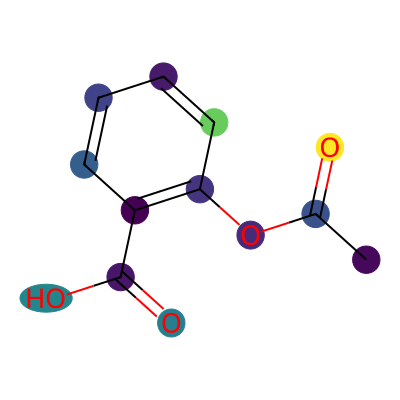

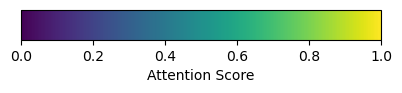

In [18]:
#6. CC(OC1=C(C(=O)O)C=CC=C1)=O CC(=O)OC1C=CC=CC=1C(O)=O
smiles="CC(OC1=C(C(=O)O)C=CC=C1)=O CC(=O)OC1C=CC=CC=1C(O)=O"
colorAtomsByAttention(smiles)

2024-06-12 18:16:29 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/smiles_atom_isomers_bart
2024-06-12 18:16:29 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/bbbp/smiles_atom_isomers


SMILES_tok:  ['C', '1', '=', 'C', 'C', '(', '=', 'C', 'C', '=', 'C', '1', 'C', '(', '=', 'O', ')', 'O', ')', 'O']
posToKeep:  [0, 3, 4, 7, 8, 10, 12, 15, 17, 19]
SMILES_tok_prep:  ['C', 'C', 'C', 'C', 'C', 'C', 'C', 'O', 'O', 'O']


2024-06-12 18:16:29 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2024-06-12 18:16:31 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head


10
before normalisation:  [0.01973738 0.0321122  0.04703133 0.10620853 0.06679316 0.0284362
 0.0369487  0.04438213 0.08234593 0.04063097]
normalized means where all values fall between 0 and 1:  [0.         0.14310926 0.31564228 1.         0.54417898 0.10059794
 0.19904117 0.28500544 0.72403974 0.24162497]
Minimum and maximum attention values: 0.0, 1.0


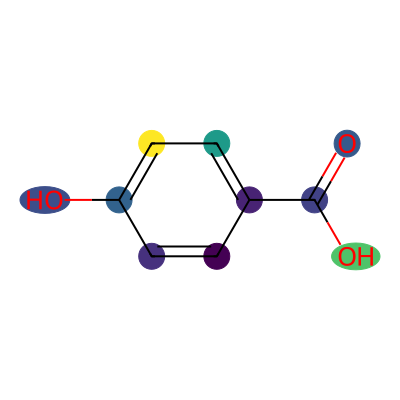

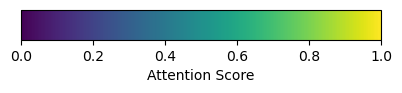

In [19]:
#7. C1=CC(=CC=C1C(=O)O)O
smiles="C1=CC(=CC=C1C(=O)O)O"
colorAtomsByAttention(smiles)

2024-06-12 18:16:33 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/smiles_atom_isomers_bart
2024-06-12 18:16:33 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/bbbp/smiles_atom_isomers


SMILES_tok:  ['C', 'C', 'C', 'C', 'O', 'C', '(', '=', 'O', ')', 'C', '1', '=', 'C', 'C', '=', 'C', '(', 'C', '=', 'C', '1', ')', 'N']
posToKeep:  [0, 1, 2, 3, 4, 5, 8, 10, 13, 14, 16, 18, 20, 23]
SMILES_tok_prep:  ['C', 'C', 'C', 'C', 'O', 'C', 'O', 'C', 'C', 'C', 'C', 'C', 'C', 'N']


2024-06-12 18:16:34 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2024-06-12 18:16:35 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head


14
before normalisation:  [0.01743455 0.04222485 0.04936155 0.08491496 0.03505463 0.11920572
 0.03120195 0.03007838 0.02873138 0.02946542 0.0221295  0.02902189
 0.02806564 0.03785704]
normalized means where all values fall between 0 and 1:  [0.         0.24358864 0.3137136  0.66306016 0.17313428 1.
 0.13527792 0.12423783 0.11100226 0.11821484 0.04613236 0.11385681
 0.10446067 0.20067062]
Minimum and maximum attention values: 0.0, 1.0


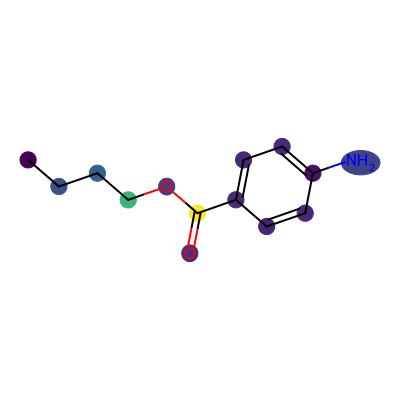

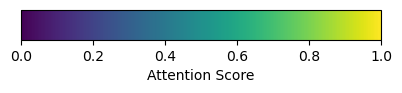

In [20]:
#8. CCCCOC(=O)C1=CC=C(C=C1)N
smiles="CCCCOC(=O)C1=CC=C(C=C1)N"
colorAtomsByAttention(smiles)